In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dotenv import load_dotenv
from time import time
from wmd import wmd
from pyemd import emd
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus
from gensim.models.fasttext import load_facebook_vectors
sns.set()

/home/dgarrido/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load environment variables
load_dotenv()

True

# 1. Load Data

In [3]:
corpus_dir = f'{os.getenv("CORPUS")}{os.getenv("SLICE_TYPE")}'
corpus_files = sorted([file for file in os.listdir(corpus_dir) if bool(re.match("corpus_\d*.mm$", file))])
dict_files = sorted([file for file in os.listdir(corpus_dir) if ".dict" in file])
models_path = f'{os.getenv("RESULTS")}hdp/{os.getenv("SLICE_TYPE")}'
models_dir = sorted(os.listdir(models_path))

slices = range(1, len(models_dir)+1)
data = {}
for slice in slices:
    # load dictionary {word->id}
    dict_path = f'{corpus_dir}/{dict_files[slice-1]}'
    token2id = Dictionary.load(dict_path).token2id

    # get term probability
    corpus_path = f'{corpus_dir}/{corpus_files[slice-1]}'
    corpus = BleiCorpus(corpus_path)
    term_frequency = np.zeros(len(token2id))
    for doc in corpus:
        for (id_word, freq) in doc:
            term_frequency[id_word]+=freq
    term_probability = term_frequency/term_frequency.sum()
    
    # load topics distributions
    topics_path = f'{models_path}/{models_dir[slice-1]}/mode-topics.dat'
    with open(topics_path, "r") as f:
        topics = np.array([[int(word) for word in line.strip().split()] for line in f])
    topics_dists = (topics.T/topics.sum(axis=1)).T

    # save data in a dict
    data[slice] = {"token2id": token2id, "topics_dists": topics_dists, "term_probability": term_probability}

# 2. Topic distributions

In [4]:
def get_quantile(array, q):
    """
    Get number of elements that represent the 100q% of cumulative distribution of an array.
    """
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    
    #get quantile 
    cut = cum_dist.max()*q
    tail = np.array(cum_dist[cum_dist<=cut])
    if len(tail)>=1:
        quantile = np.argmax(tail)+1
    else:
        quantile = 1
    
    return quantile


def get_mean_cum_dist(data, alpha=1):
    """
    Get %vocab used to satisfy certain level of cum dist
    """
    quantiles=np.arange(0.01,1+0.01, 0.01)
    slices = list(data.keys())
    vocab_cum_dist = []
    for slice in slices:
        topics = data[slice]["topics_dists"]
        term_probability = data[slice]["term_probability"]
        K, V = topics.shape
        for k in range(K):
            topic_weights = relevance(topics[k], term_probability, alpha)
            cum_dist = np.array([get_quantile(topic_weights, q) for q in  quantiles])/V
            vocab_cum_dist.append(cum_dist)
    vocab_cum_dist = np.array(vocab_cum_dist).mean(axis=0)
    
    return vocab_cum_dist

def cum_dist_plot(cum_dist, figsize=(9,6)):
    quantiles=np.arange(0.01,1+0.01, 0.01)
    q_indexs = [0.6, 0.8, 0.9, 0.95, 0.99]
    labels = [f"q{int(100*q)}" for q in q_indexs] 
    q_values = [cum_dist[int(100*q)-1] for q in q_indexs]
    
    #plot cdf
    fig, ax = plt.subplots(figsize=figsize)        
    ax.plot(cum_dist,  quantiles)

    #plot quantiles
    ax.scatter(q_values, q_indexs)
    for i, label in enumerate(labels):
        ax.annotate(label, (q_values[i], q_indexs[i]))    
    return ax

Text(0, 0.5, 'Acumulado del tópico')

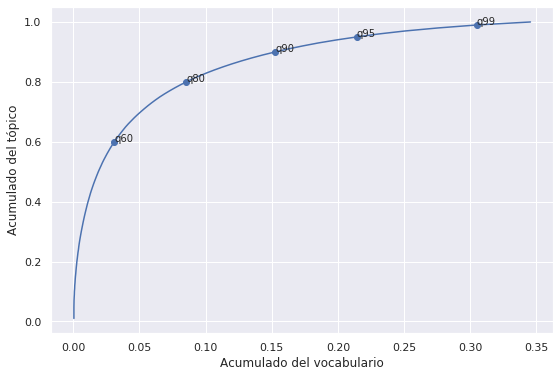

In [19]:
topics_cum_dist = get_mean_cum_dist(data)
ax = cum_dist_plot(topics_cum_dist)
ax.set_xlabel("Acumulado del vocabulario")
ax.set_ylabel("Acumulado del tópico")

In [20]:
q95_list = []
for slice in slices:
    topics = data[slice]["topics_dists"]
    topics.shape
    for i, topic in enumerate(topics):
        q95 = get_quantile(topic, 0.95)
        q95_list.append({"slice":slice, "topic":i, "vocabulary_size": len(topic),
                         "%q95":round(100*q95/len(topic),2)})

In [23]:
df_q95 = pd.DataFrame(q95_list)
df_q95.head()

,slice,topic,vocabulary_size,%q95
0,1,0,1919,33.98
1,1,1,1919,25.27
2,1,2,1919,35.23
3,1,3,1919,32.73
4,1,4,1919,27.25


In [24]:
df_q95[["slice", "vocabulary_size", "%q95"]].groupby("slice").describe()

vocabulary_size                                                       \
                count    mean  std     min     25%     50%     75%     max   
slice                                                                        
1                 8.0  1919.0  0.0  1919.0  1919.0  1919.0  1919.0  1919.0   
2                10.0  1986.0  0.0  1986.0  1986.0  1986.0  1986.0  1986.0   
3                 9.0  2092.0  0.0  2092.0  2092.0  2092.0  2092.0  2092.0   
4                 8.0  2414.0  0.0  2414.0  2414.0  2414.0  2414.0  2414.0   
5                 8.0  2629.0  0.0  2629.0  2629.0  2629.0  2629.0  2629.0   
6                 9.0  2666.0  0.0  2666.0  2666.0  2666.0  2666.0  2666.0   

       %q95                                                               
      count       mean        std   min      25%     50%      75%    max  
slice                                                                     
1       8.0  24.272500  11.862198  0.89  22.0800  26.785  33.0425  35.23  
2      10.0  17.533000  15.477216  0.05   0.6275  21.250  30.8800  36.61  
3       9.0  20.990000  13.801090  0.05   8.8900  28.440  30.3500  32.41  
4       8.0  21.645000  14.996002  0.17  10.9775  26.285  34.0600  36.95  
5       8.0  24.638750  10.850875  0.30  24.1725  26.970  29.7625  34.39  
6       9.0  20.563333  12.935772  1.65  11.8900  24.570  30.9500  36.83

In [25]:
df_q95["%q95"].describe()

count    52.000000
mean     21.418462
std      13.068000
min       0.050000
25%      11.140000
50%      26.560000
75%      31.530000
max      36.950000
Name: %q95, dtype: float64

In [26]:
df_q95["%q95"].quantile([0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.60    28.3680
0.70    30.7700
0.80    32.6660
0.90    34.3780
0.95    35.8510
0.99    36.8888
Name: %q95, dtype: float64

Se tiene que en promedio con un 8.54% y 21.42% del vocabulario se puede capturar un 80% y 95% respectivamente de la distribución acumulada de los tópicos, además, para un 99% de los tópicos basta con un 37% del vocabulario para capturar el 95% de su distribución acumulada, por tanto, una representación incompleta de los tópicos usando las palabras más probables que capturan el 80% de la distribución acumulada trae consigo una disminución importante en el tamaño del vocabulario. 

## Using relevance

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'Acumulado del tópico')

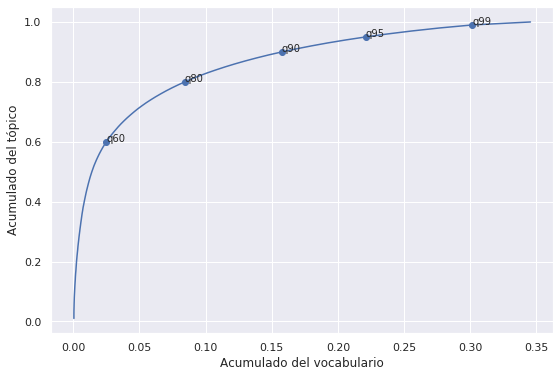

In [6]:
topics_cum_dist = get_mean_cum_dist(data, alpha=0)
ax = cum_dist_plot(topics_cum_dist)
ax.set_xlabel("Acumulado del vocabulario")
ax.set_ylabel("Acumulado del tópico")

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'Acumulado del tópico')

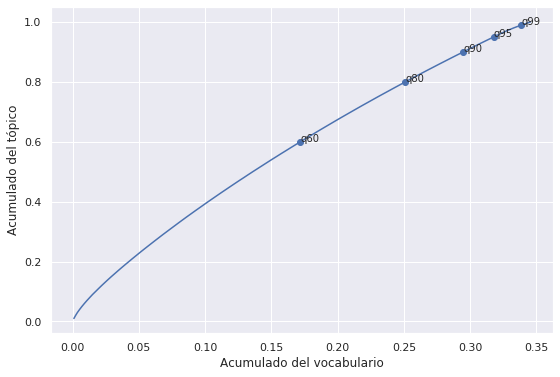

In [7]:
topics_cum_dist = get_mean_cum_dist(data, alpha=0.6)
ax = cum_dist_plot(topics_cum_dist)
ax.set_xlabel("Acumulado del vocabulario")
ax.set_ylabel("Acumulado del tópico")

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Text(0, 0.5, 'Acumulado del tópico')

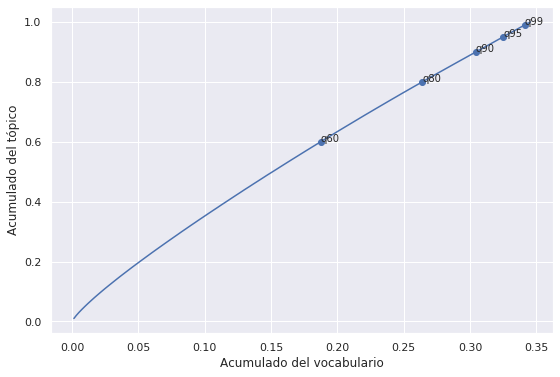

In [8]:
topics_cum_dist = get_mean_cum_dist(data, alpha=1)
ax = cum_dist_plot(topics_cum_dist)
ax.set_xlabel("Acumulado del vocabulario")
ax.set_ylabel("Acumulado del tópico")

# 3. Distances

In [9]:
embeddings = load_facebook_vectors(os.getenv("EMBEDDINGS"))

In [245]:
token2id1 = data[1]["token2id"]
token2id2 = data[2]["token2id"]
topic1 = data[1]["topics_dists"][0]
topic2 = data[2]["topics_dists"][0]

In [265]:
%time wmd(embeddings, token2id1, token2id2, topic1, topic2, q=None)

INFO:similarity-graph:'wmd'  161.61 [s]


CPU times: user 2min 42s, sys: 335 ms, total: 2min 42s
Wall time: 2min 41s


2.9336220902293917

In [264]:
%time wmd(embeddings, token2id1, token2id2, topic1, topic2, q=0.95)

INFO:similarity-graph:'wmd'  39.22 [s]


CPU times: user 39.9 s, sys: 181 ms, total: 40.1 s
Wall time: 39.2 s


2.866016659418769

In [263]:
%time wmd(embeddings, token2id1, token2id2, topic1, topic2, q=0.8)

INFO:similarity-graph:'wmd'  1.65 [s]


CPU times: user 2.19 s, sys: 75.7 ms, total: 2.27 s
Wall time: 1.65 s


2.481585721953469

# 4. Test EMD

Testing if EMD normalize each histogram.

In [27]:
histogram1 = np.array([1, 5, 3]).astype(float)
histogram2 = np.array([0.3, 0.2, 0.5]).astype(float)
cost_matrix = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]]).astype(float)

In [30]:
emd(histogram1, histogram2, cost_matrix)

16.0

In [31]:
histogram1 = histogram1/histogram1.sum()

In [32]:
emd(histogram1, histogram2, cost_matrix)

0.355556

Is necessary normalize the topics again when is used the cdf threshold.

# 5. WMD with relevance

In [143]:
token2id1 = data[1]["token2id"]
token2id2 = data[2]["token2id"]
topic1 = data[1]["topics_dists"][0]
topic2 = data[2]["topics_dists"][3]
termp1 = data[1]["term_probability"]
termp2 = data[2]["term_probability"]

In [152]:
d = wmd(embeddings, token2id1, token2id2, topic1, topic2, termp1, termp2, q=0.8, alpha=0.4)
s = 1/(1+d)
s

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


0.49981030841254026